c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Mustafa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

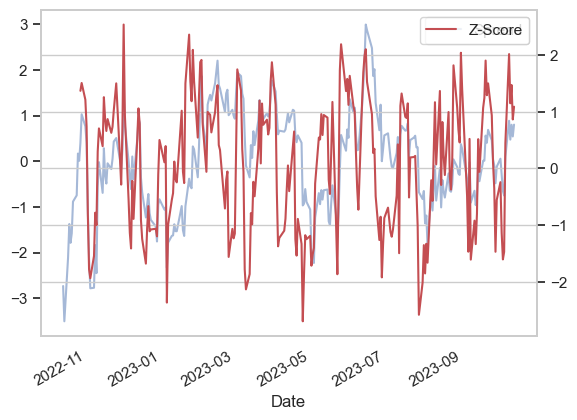

In [1]:
import numpy as np
import pandas as pd

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import yfinance as yf

stock_1 = 'CIBR'
stock_2 = 'IONQ'
stock_list = [stock_1, stock_2]
window_size = 11

end_date = pd.Timestamp.today()
start_date =  end_date - pd.Timedelta(days = 365)
df = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']

Y = df[stock_1]
X = df[stock_2]
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
spread = Y - model.predict()
spread = spread.rename("Spread")

spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = ((spread - spread_mean)/spread_std)
first_valid_idx = zscore.first_valid_index()
zscore = zscore.rename("Z-Score")

plot_df_zscore = pd.merge(spread, zscore, right_index = True, left_index = True)
plot_df_zscore.plot(y='Spread', grid=False, color='b', alpha=0.50)
ax2 = plt.twinx()
plot_df_zscore.plot(y='Z-Score', ax=ax2, color='r')

<Axes: xlabel='Date'>

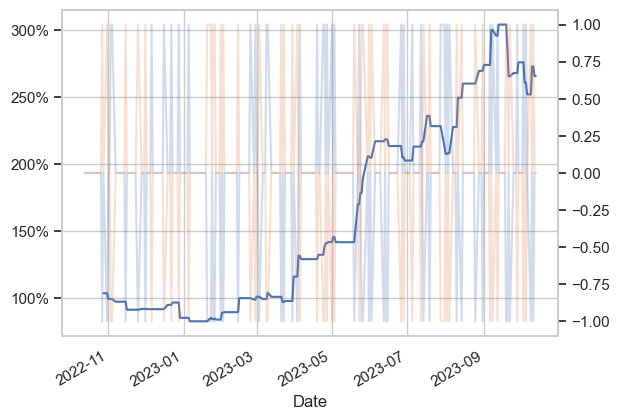

In [2]:
from matplotlib.ticker import PercentFormatter 

entry_threshold = 1.1
exit_threshold = 1.9
share_ratio = 0.1

stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)

for i in range(1, len(zscore)):
    if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = 1
        stock2_position.iloc[i] = -1
    elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = -1
        stock2_position.iloc[i] = 1
    elif abs(zscore.iloc[i]) < exit_threshold:
        stock1_position.iloc[i] = 0
        stock2_position.iloc[i] = 0
    else:
        stock1_position.iloc[i]=stock1_position.iloc[i-1]
        stock2_position.iloc[i]=stock2_position.iloc[i-1]

stock1_returns = df[stock_1][first_valid_idx:].pct_change() * stock1_position.shift(1).fillna(0)
stock2_returns = df[stock_2][first_valid_idx:].pct_change() * stock2_position.shift(1).fillna(0)

total_returns = share_ratio * stock1_returns + (1-share_ratio) * stock2_returns
cumulative_returns = (1 + total_returns).cumprod()
cumulative_returns.iloc[0] = 1

cumulative_returns = cumulative_returns*100
cumulative_returns.plot().yaxis.set_major_formatter(PercentFormatter())
ax2 = plt.twinx()
stock1_position.plot(ax=ax2, alpha = 0.25, grid = False)
stock2_position.plot(ax=ax2, alpha = 0.25, grid = False)

In [3]:
def cointegration_test(X, Y, cutoff=0.1, print_results=False):
    #Engle-Granger test for cointegration
    score, pvalue, _ = coint(X, Y)
    if print_results == True:
        if pvalue < cutoff:
            print('p-value = ' + str(pvalue) + '; the pair ' + X.name + ' and ' + Y.name + ' is likely cointegrated.')
        else:
            pass
            #print('p-value = ' + str(pvalue) + '; the pair ' + X.name + Y.name + ' is likely not cointegrated.')
    else:
        pass
    return pvalue

def stationarity_test(X, cutoff=0.01, print_results=False):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if print_results == True:
        if pvalue < cutoff:
            print('p-value = ' + str(pvalue) + '; the series ' + X.name +' is likely stationary.')
        else:
            pass
            #print('p-value = ' + str(pvalue) + '; the series ' + X.name +' is likely non-stationary.')
    else:
        pass
    return pvalue

def read_position(pos):
    if pos == 1:
        return("Long")
    if pos == -1:
        return("Short")
    if pos == 0:
        return("EXIT")

budget = 1000
exposure_risk = 0.10
wager = budget * exposure_risk

p_value = cointegration_test(df[stock_1], df[stock_2], print_results = True)
spread_stationarity_pvalue = stationarity_test(spread, print_results=True)

print(read_position(stock1_position.iloc[-1]), stock_1)
print(read_position(stock2_position.iloc[-1]), stock_2)

stock1_price = np.round(df[stock_1].iloc[-1], 2)
stock2_price = np.round(df[stock_2].iloc[-1], 2)

stock1_ideal_value = (share_ratio*wager)
stock2_ideal_value = (1-share_ratio)*wager

stock1_actual_shares = np.floor(stock1_ideal_value/stock1_price)
stock2_actual_shares = np.floor(stock2_ideal_value/stock2_price)

stock1_actual_value = np.round(stock1_actual_shares * stock1_price, 2)
stock2_actual_value = np.round(stock2_actual_shares * stock2_price, 2)
    
print("This corresponds to:")
if stock1_position.iloc[-1] != 0:
    print(f"{read_position(stock1_position.iloc[-1])} {stock1_actual_shares} share(s) of {stock_1} for {stock1_actual_value}")
else:
    print(f"{read_position(stock1_position.iloc[-1])} share(s) of {stock_1}")

if stock2_position.iloc[-1] != 0:
    print(f"{read_position(stock2_position.iloc[-1])} {stock2_actual_shares} share(s) of {stock_2} for {stock2_actual_value}")
else:
    print(f"{read_position(stock2_position.iloc[-1])} share(s) of {stock_2}")

p-value = 0.0020634589322913806; the pair CIBR and IONQ is likely cointegrated.
p-value = 0.0003617784297730045; the series Spread is likely stationary.
EXIT CIBR
EXIT IONQ
This corresponds to:
EXIT share(s) of CIBR
EXIT share(s) of IONQ
